<h2 align=center> Toxic Comments Classification using CNN with Keras</h2>

# 

## Part 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


#    
## Part 2: Load and Explore Data

In [2]:
# Dataset of Wikipedia comments
train_df = pd.read_csv('~/Desktop/projects/Toxic_Comments_Classification/train.csv').fillna(' ')
train_df.sample(5, random_state=1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0


In [3]:
x = train_df['comment_text'].values
print(x[3])

"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.

There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "


In [4]:
# View a sample of toxic comments
train_df.loc[train_df['toxic']==1].sample(5, random_state=10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
30575,512e03958d8615e4,"""\n Are you asking if we would ever block some...",1,0,0,0,0,0
36038,60506a63b56bc539,Amen my sock-pupinski brother!! Hack-a-long: p...,1,0,0,0,0,0
19730,341c484d858e4441,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1,0,1,0,0,0
72261,c1723b16ec5d9979,u no wat ass hole go fuck your self and stop b...,1,0,1,0,1,0
77923,d0a55e6ffaa62b3d,Go fuck yourself \n\nEat shit and die. 68.0.11...,1,1,1,1,1,0


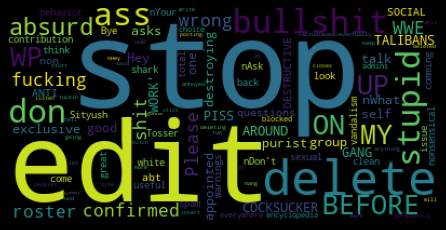

In [5]:
# Create word cloud of toxic words
text = train_df['comment_text'].loc[train_df['toxic']==1].values

wordcloud = WordCloud(
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (6, 3),
                 facecolor = 'k')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Some words are so inappropriate to display.... These seem to be toxic, indeed.

In [6]:
# Separate x and y
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


<AxesSubplot:title={'center':'Distribution of Toxic Comments'}, ylabel='Frequency'>

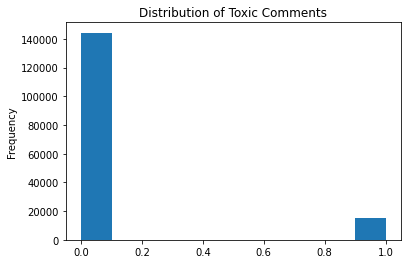

In [7]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist', title='Distribution of Toxic Comments')

In [8]:
N, T = train_df['toxic'].value_counts()
print(f"Number of non-toxic comments:", N)
print(f"Number of toxic comments:", T)
print("Percentage of toxic comments:", round((T/N)*100,2), "%")

Number of non-toxic comments: 144277
Number of toxic comments: 15294
Percentage of toxic comments: 10.6 %


#    
## Part 3: Prep Data — Tokenize and Pad Text Data

In [9]:
# Tokenizing sentences to maximum of 20000 tokens
max_features = 20000

# Set text length to be 400
max_text_length = 400

In [10]:
# Create an instance of tokenizer
x_tokenizer = tf.keras.preprocessing.text.Tokenizer(max_features)

# Create the vocabulary index based on word frequency 
x_tokenizer.fit_on_texts(list(x))

# Transforms each text to a sequence of integers.
x_tokenized = x_tokenizer.texts_to_sequences(x) 

# Transform a list of sequences into a 2D Numpy array of shape 
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [11]:
# Making sure the shapes are all correct
print(x_train_val.shape)
print(y.shape)

(159571, 400)
(159571,)


In [12]:
# Look at an examle (3rd comment)
print('***Original Comment:', x[2])
print('***Number of words in this comment:', len(x[2].split()))

print('***Length of the sequence of text after tokenizing:', len(x_tokenized[2]))
print('***Length of the sequence of text after tpadding:',len(x_train_val[1]))

***Original Comment: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
***Number of words in this comment: 42
***Length of the sequence of text after tokenizing: 42
***Length of the sequence of text after tpadding: 400


#    
## Part 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [13]:
# I download the GloVe embeddings:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [14]:
embedding_dims = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [15]:
embedding_matrix = np.zeros((max_features, embedding_dims))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [16]:
print("The shape of the embeddding matrix is:", embedding_matrix.shape)

The shape of the embeddding matrix is: (20000, 100)


#      
## Part 5: Create Embedding Layer

In [17]:
model = Sequential()

model.add(Embedding(max_features,
                    embedding_dims,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), # load pre-trained word embeddings
                    trainable=False)) # keep the embeddings fixed while training

# Add regularization 
model.add(Dropout(0.2))

#     
## Part 6: Build the Model

In [18]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [19]:
# Build model
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 kernel_size=5,
                 padding='valid',
                 activation='relu'))
# We use max pooling:
model.add(GlobalMaxPooling1D())
# We add a hidden layer:
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
# We project onto 6 output layers, and squash it with a sigmoid
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [20]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#         
## Part 6: Train Model

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size=0.15, random_state=1)

In [22]:
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

(135635, 400)
(23936, 400)
(135635,)
(23936,)


In [23]:
print(x_train[1])
print(y_train[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [24]:
batch_size = 32
epochs = 3

In [25]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 775s 183ms/step - loss: 0.1441 - accuracy: 0.9479 - val_loss: 0.1168 - val_accuracy: 0.9560
Epoch 2/3
4239/4239 [==============================] - 769s 181ms/step - loss: 0.1192 - accuracy: 0.9563 - val_loss: 0.1134 - val_accuracy: 0.9586
Epoch 3/3
4239/4239 [==============================] - 783s 185ms/step - loss: 0.1086 - accuracy: 0.9594 - val_loss: 0.1190 - val_accuracy: 0.9598


#   
## Part 7: Evaluate Model

In [26]:
model.evaluate(x_val, y_val, batch_size=128)

187/187 [==============================] - 41s 217ms/step - loss: 0.1190 - accuracy: 0.9598


[0.1189827099442482, 0.9598094820976257]

Our model yields with a 95% accuracy

In [27]:
# Read in test set
test_df = pd.read_csv('./test.csv')

In [28]:
# Extract texts from the test set
x_test = test_df['comment_text'].values

In [29]:
# Turn texts into sequences
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [30]:
# Predict whether a comment is toxic
y_pred = model.predict(x_testing, verbose = 1, batch_size=32)

4787/4787 [==============================] - 272s 57ms/step


In [32]:
y_pred.shape

(153164, 1)

In [34]:
# When y >= 0.5, consider it toxic
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_pred]
test_df[['comment_text', 'Toxic']].head(10)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
